In [1]:
import numpy as np
import numpy.random as np_rand
import scipy.special as sc
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from scipy.io import arff
from numpy.lib.recfunctions import structured_to_unstructured
from timeit import default_timer


## Simulated data

In [2]:
# Define parameters
k = 20 # truncation level for truncated drichlet process
alpha = 5 # concentration parameter for DP
n_samples = 100 # Number of X sample points to generate
num_of_gaussian_dim = 2 # Number of dimensions in Gaussian distribution from which X will be sampled
rho = 0.8 # first-order autocorrelation coefficient for covariance matrix of Gaussian distribution from which X will be sampled
variance_prior = 100 # variance of Gaussian baseline distribution in DP
variance_sample = 4 # variance of the gaussion from which X will be sampled


In [3]:
# Generate the baseline 2-dim Gaussion distribution prior of DP
base_mean = np.zeros(num_of_gaussian_dim) # zero-mean Gaussian
base_cov = np.eye(num_of_gaussian_dim) * variance_prior # scaled for comparison across dimensions (values should be of similar order)

#base_cov = [[100, 0], [0, 100]]
print("base_mean: \n", base_mean)
print("base_cov: \n", base_cov)

base_mean: 
 [0. 0.]
base_cov: 
 [[100.   0.]
 [  0. 100.]]


In [4]:
# Generate eta from baseline distribution of DP (Unique values of means(each per dim) from the 2-dim gaussion prior distribution of DP)
eta_params = np_rand.multivariate_normal(base_mean, base_cov, size=k)
#means = norm.rvs(base_mean, base_cov) # draw normal random variables for means
print("eta_params:\n", eta_params)

eta_params:
 [[ -6.32645088   1.06861929]
 [-17.48865749  10.25867797]
 [  7.2916691   -2.15632773]
 [-20.81330095  -9.35019163]
 [ 15.79408842  -0.16858394]
 [-12.61540012  -6.91811707]
 [  0.98771294   9.87468756]
 [-23.41126397   6.59618301]
 [ -4.97235999  -1.75416612]
 [-18.00412052  14.77485306]
 [ -8.45628752  10.79576746]
 [ -2.19774897   7.19289568]
 [  5.03462197  -6.76522457]
 [ 17.55758654   4.75498699]
 [  4.71431008  -2.69474453]
 [  1.89835484  10.99980388]
 [ -1.92710716   2.74904087]
 [  9.66379329   6.04913121]
 [ -3.1643819    9.53005386]
 [  8.1619033  -36.98378319]]


In [5]:
# DP using stick-breaking technique
V_params = np_rand.beta(1, alpha, size=k)
V_params[k-2] = 1 #Truncate DP construction at K by setting V_K-1 = 1, but in our case k index start from 0
print("V_params:\n ", V_params)

theta_params = np.zeros(k) # initialize the theta_params
remaining_stick = 1 # initialize the remaining stick length
for i in range(k):
    theta_params[i] = V_params[i] * remaining_stick # break the stick
    remaining_stick *= (1 - V_params[i]) # update the remaining stick length
print("theta_params:\n ", theta_params)

V_params:
  [0.08095195 0.01202607 0.17799483 0.22151003 0.27737601 0.29068789
 0.41523046 0.02248585 0.29564124 0.26971895 0.03345915 0.10834635
 0.11877997 0.15533787 0.01237522 0.24068745 0.41044466 0.06588451
 1.         0.29295273]
theta_params:
  [0.08095195 0.01105254 0.16161851 0.16533    0.1611685  0.1220536
 0.12366597 0.00391611 0.0503308  0.03234255 0.00293    0.00917038
 0.00896422 0.01033073 0.00069517 0.0133531  0.01729035 0.00163628
 0.02319927 0.        ]


In [6]:
# Generate the first-order autocorrelation fixed covariance matrix of Gaussian distribution from which X will be sampled
cov = np.zeros((num_of_gaussian_dim, num_of_gaussian_dim)) # initialize the covariance matrix
for i in range(num_of_gaussian_dim):
    for j in range(num_of_gaussian_dim):
            cov[i, j] = variance_sample*(rho ** abs(i - j)) # assign the value based on the distance

#cov = [[3, 0.95], [0.95, 3]]
print('cov matrix: \n', cov)

cov matrix: 
 [[4.  3.2]
 [3.2 4. ]]


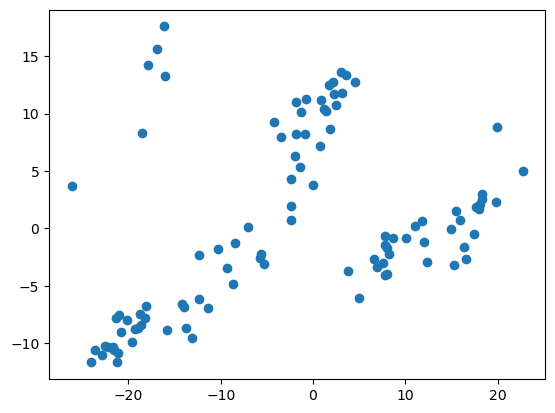

In [7]:
# Generate the samples from the Gaussion-Gaussion distribution
samples = np.zeros((n_samples, num_of_gaussian_dim)) # initialize the data matrix
z_params = np.zeros(n_samples, dtype=int) # initilize the z parameter

for i in range(n_samples):
    z_params[i] = np_rand.choice(k, p=theta_params) # assign a cluster to each sample point
    samples[i] = np_rand.multivariate_normal(eta_params[z_params[i]], cov) # draw a Sample point from the assigned cluster

# print("Samples: \n", samples)
plt.scatter(samples[:,0],samples[:,1])

In [8]:
import itertools
import matplotlib as mpl
from scipy import linalg

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange", "grey", "green"])

def plot_results(X, Y_, means, covariances, title):
    """
    Plot gaussian components as ellipses
    """
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # covar = np.diag(covar)
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.3)
        splot.add_artist(ell)
    plt.title(title)

In [9]:
# The scipy BGM do not provide a variance-fixed gaussian component option. 
bgm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=None, n_init=1, covariance_type="full", max_iter=1000, verbose=2)
bgm.fit(samples)

Initialization 0
  Iteration 10	 time lapse 0.47015s	 ll change 0.02240
Initialization converged: True	 time lapse 0.47015s	 ll -629.73416


BayesianGaussianMixture(max_iter=1000, n_components=20, verbose=2)

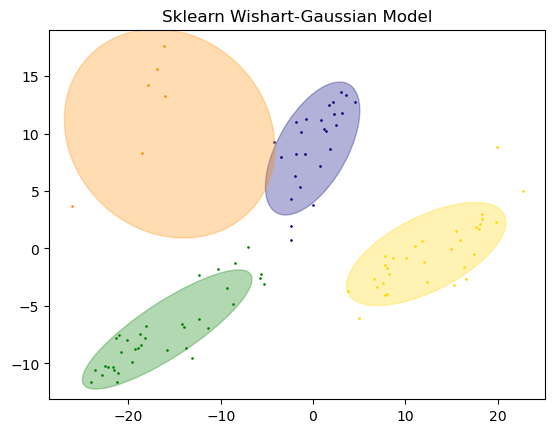

In [10]:
plot_results(samples, bgm.predict(samples), bgm.means_, bgm.covariances_, "Sklearn Wishart-Gaussian Model")

### Spherical covariance model

In [11]:
from scipy.special import logsumexp

M = 51

def plot_contour(model, x, x_min, x_max, y_min, y_max):
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, M), np.linspace(y_min, y_max, M))
    
    xy = np.stack((xv, yv), axis=-1).reshape((M * M, 2))
    prob = logsumexp(model.predict(xy), axis=1)
    z = np.reshape(prob, (M, M))

    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], 0.8)
    CS = plt.contour(xv, yv, z)
    plt.clabel(CS)
    plt.show()
    

Iter  0 elbo = -1162.6326446826185
Iter  10 elbo = -827.2790006595918
Iter  20 elbo = -796.1641090550031
Iter  30 elbo = -775.0021540755831
Converge at iter 39
ELBO = -774.9247087800615


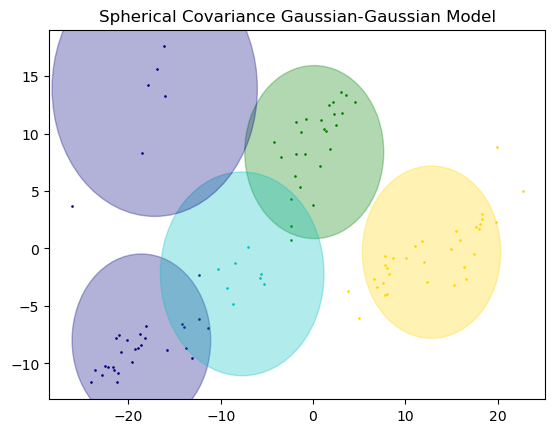

In [12]:
# Our model assume a fixed covariance in each component
from dp import *

eps = 1e-3
var_samples = np.var(samples, axis=0)
mu_samples = np.mean(samples, axis=0)

# Initialization
sigma0 = (np.prod(var_samples) ** 0.5) # Variance on each dimension, in each component
sigma = sigma0 / k # Baseline variance, on each dimension
dp = DpGaussianSpherical(samples, alpha=1e0, sigma=sigma, mu0=mu_samples, sigma0=sigma0, K=k)

elbo = - np.inf

# CAVI update
for i in range(1000):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if i % 10 == 0:
        print("Iter ", i, "elbo =", elbo)
    if abs(elbo - prev_elbo) < eps:
        print("Converge at iter", i)
        break

print("ELBO =", elbo)
prob = dp.predict(samples)
label = np.argmax(prob, axis=1)

sigma_x = np.zeros((k, 2, 2))
for i in range(k):
    sigma_x[i] = np.identity(2) * (dp.sigma ** 2 + dp.sigma_p[i] ** 2)

plot_results(samples, label, dp.mu_p, sigma_x, "Spherical Covariance Gaussian-Gaussian Model")

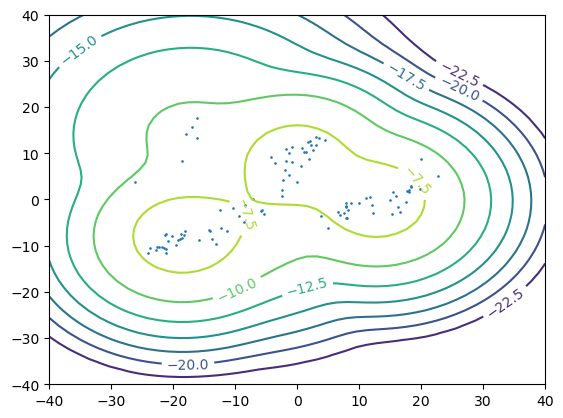

In [13]:
plot_contour(dp, samples, -40, 40, -40, 40)

### Full covariance model

Iter  0 elbo = -6512.098713939174
Iter  10 elbo = -1203.2554362051158
Iter  20 elbo = -1191.7689435489458
Iter  30 elbo = -1190.767994829234
Iter  40 elbo = -1185.269617248376
Converge at iter 41
ELBO = -1185.2686242117852


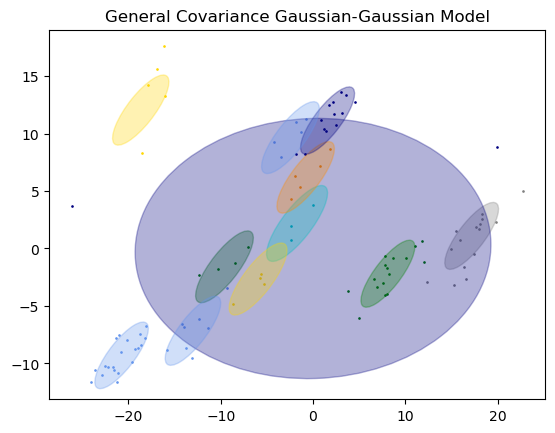

In [14]:

# Initialization
cov_samples = np.cov(samples.T)
# Sigma = np.diag(var_samples) / k ** 0.5 # Covariance matrix of each component
Sigma = cov # Covariance matrix of each component
Sigma0 = np.diag(var_samples) # Baseline covariance
# Sigma0 = base_cov # Baseline covariance
dp = DpGaussianFull(samples, alpha=1e0, Sigma=Sigma, mu0=np.zeros((2,)), Sigma0=Sigma0, K=k)

elbo = - np.inf

# CAVI update
for i in range(1000):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if i % 10 == 0:
        print("Iter ", i, "elbo =", elbo)
    if abs(elbo - prev_elbo) < eps:
        print("Converge at iter", i)
        break

print("ELBO =", elbo)
prob = dp.predict(samples)
label = np.argmax(prob, axis=1)
plot_results(samples, label, dp.mu_p, dp.Sigma + dp.Sigma_p, "General Covariance Gaussian-Gaussian Model")

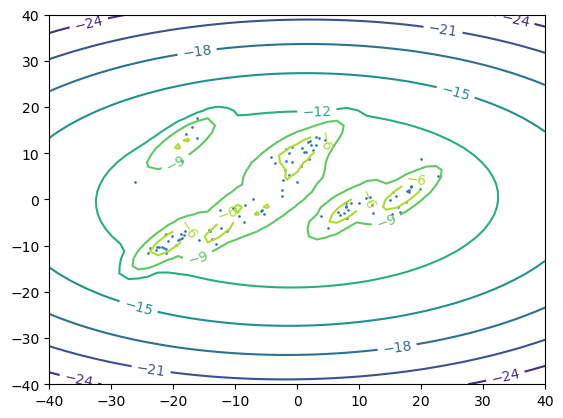

In [15]:
plot_contour(dp, samples, -40, 40, -40, 40)

## Robot data

In [46]:
from scipy.io import arff
import time

data, meta = arff.loadarff("dataset/dataset_2175_kin8nm.arff")
data = np.lib.recfunctions.structured_to_unstructured(data)

train_size = 7000
heldout_size = 250

train_data = data[0:train_size, 0:9]
cov_data = np.cov(train_data.T)
var_data = np.var(train_data, axis=0)
mean_data = np.mean(train_data, axis=0)

print(data[0,:])
print(train_data[0,:])
print(k*var_data)
print(cov_data)

[-0.01511921  0.36074091  0.46939777  1.3096745   0.98802387 -0.02549255
  0.66407094  0.062763    0.53652416]
[-0.01511921  0.36074091  0.46939777  1.3096745   0.98802387 -0.02549255
  0.66407094  0.062763    0.53652416]
[16.34419266 16.33529057 16.22155462 16.26205813 16.60431987 16.59134749
 16.45065031 16.3809758   1.3890461 ]
[[ 8.17326394e-01 -2.11888657e-04  7.65609179e-04 -9.84542530e-03
   5.11751655e-04  1.71433626e-02  3.02528939e-04 -9.21380422e-03
  -3.45699525e-02]
 [-2.11888657e-04  8.16881226e-01 -1.36857542e-02 -8.70528350e-04
   6.78594652e-03  8.76499208e-03  6.75673345e-03 -7.64509590e-04
  -1.85629219e-02]
 [ 7.65609179e-04 -1.36857542e-02  8.11193616e-01 -7.57723693e-03
   2.28769644e-03 -4.67608042e-03 -5.85394301e-03 -8.78657096e-03
  -1.24219085e-01]
 [-9.84542530e-03 -8.70528350e-04 -7.57723693e-03  8.13219080e-01
  -2.86895806e-03  5.51287847e-03  1.12907961e-02  1.92049310e-02
  -2.11655308e-02]
 [ 5.11751655e-04  6.78594652e-03  2.28769644e-03 -2.86895806e-

Data generation with Infinite iterations

In [75]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=0.1, Sigma=cov_data, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(10000):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

heldout_data = data[train_size: train_size + heldout_size, 0:9]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Iter  0 elbo = -76191.70047712672
Iter  10 elbo = -76191.23196549839
Iter  20 elbo = -76190.60545496253
Iter  30 elbo = -76189.76278561946
Iter  40 elbo = -76188.61905014739
Iter  50 elbo = -76187.04455165424
Iter  60 elbo = -76184.82684147771
Iter  70 elbo = -76181.57471548296
Iter  80 elbo = -76176.38281656704
Iter  90 elbo = -76165.18581850998
Iter  100 elbo = -76147.1943637894
Iter  110 elbo = -76123.80513205857
Iter  120 elbo = -76110.25073040026
Iter  130 elbo = -76087.09356860013
Iter  140 elbo = -76066.03424027827
Iter  150 elbo = -76050.80779949091
Iter  160 elbo = -76026.79246734422
Iter  170 elbo = -76004.89370127418
Iter  180 elbo = -75993.06704779864
Iter  190 elbo = -75970.75823370655
Iter  200 elbo = -75962.06226099352
Iter  210 elbo = -75940.90673403237
Iter  220 elbo = -75933.61540158464
Iter  230 elbo = -75912.29207666276
Iter  240 elbo = -75907.70107343154
Iter  250 elbo = -75898.21721621868
Iter  260 elbo = -75880.21133914473
Iter  270 elbo = -75875.6658657172
Iter 

In [87]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=0.001*1e1, Sigma=cov_data, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(10000):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

heldout_data = data[train_size: train_size + heldout_size, 0:9]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Iter  0 elbo = -77900.67497468955
Iter  10 elbo = -77900.21201218097
Iter  20 elbo = -77899.59118778893
Iter  30 elbo = -77898.75375682264
Iter  40 elbo = -77897.61346110057
Iter  50 elbo = -77896.03737395526
Iter  60 elbo = -77893.80454039425
Iter  70 elbo = -77890.49671248418
Iter  80 elbo = -77885.08143493862
Iter  90 elbo = -77871.39886573472
Iter  100 elbo = -77854.77048961108
Iter  110 elbo = -77832.68180841299
Iter  120 elbo = -77817.27853078094
Iter  130 elbo = -77790.29231961543
Iter  140 elbo = -77771.74901740358
Iter  150 elbo = -77753.41754840984
Iter  160 elbo = -77726.00650902076
Iter  170 elbo = -77712.33637279815
Iter  180 elbo = -77688.91727742304
Iter  190 elbo = -77663.74460947633
Iter  200 elbo = -77655.34961706665
Iter  210 elbo = -77630.91936545674
Iter  220 elbo = -77622.79167026108
Iter  230 elbo = -77599.81926960894
Iter  240 elbo = -77594.39383752966
Iter  250 elbo = -77578.47014910975
Iter  260 elbo = -77565.34917390325
Iter  270 elbo = -77559.26739184833
Ite

In [88]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=0.0001*1e1, Sigma=cov_data, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(10000):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

heldout_data = data[train_size: train_size + heldout_size, 0:9]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Iter  0 elbo = -95000.5864689909
Iter  10 elbo = -95000.12981683701
Iter  20 elbo = -94999.51785682936
Iter  30 elbo = -94998.69311986225
Iter  40 elbo = -94997.57156056439
Iter  50 elbo = -94996.02441688851
Iter  60 elbo = -94993.83961326137
Iter  70 elbo = -94990.62217074804
Iter  80 elbo = -94985.43133091662
Iter  90 elbo = -94973.46571062037
Iter  100 elbo = -94952.9444828252
Iter  110 elbo = -94935.3630495032
Iter  120 elbo = -94911.45198595073
Iter  130 elbo = -94883.9223134733
Iter  140 elbo = -94868.9984625559
Iter  150 elbo = -94843.68541192343
Iter  160 elbo = -94814.9946920723
Iter  170 elbo = -94803.59675746443
Iter  180 elbo = -94774.96836275439
Iter  190 elbo = -94746.76258373761
Iter  200 elbo = -94737.70251944111
Iter  210 elbo = -94711.22432795918
Iter  220 elbo = -94701.51771514848
Iter  230 elbo = -94677.73746465317
Iter  240 elbo = -94670.91060394688
Iter  250 elbo = -94645.55374058803
Iter  260 elbo = -94642.14263166732
Iter  270 elbo = -94636.51809759301
Iter  280

Data generation with fixed 500 iterations

In [93]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=0.01*1e1, Sigma=cov_data, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(500):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

heldout_data = data[train_size: train_size + heldout_size, 0:9]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Iter  0 elbo = -76191.75734501834
Iter  10 elbo = -76191.30729054377
Iter  20 elbo = -76190.70548704808
Iter  30 elbo = -76189.89624541908
Iter  40 elbo = -76188.79843526526
Iter  50 elbo = -76187.28851612608
Iter  60 elbo = -76185.16510639884
Iter  70 elbo = -76182.06043362677
Iter  80 elbo = -76177.13790670177
Iter  90 elbo = -76166.88780257839
Iter  100 elbo = -76148.70719562842
Iter  110 elbo = -76130.22460584212
Iter  120 elbo = -76113.75675078563
Iter  130 elbo = -76088.500658087
Iter  140 elbo = -76070.72280703086
Iter  150 elbo = -76054.12468203867
Iter  160 elbo = -76029.6698335469
Iter  170 elbo = -76017.6860337043
Iter  180 elbo = -75997.39543548075
Iter  190 elbo = -75983.00359857125
Iter  200 elbo = -75963.80576321622
Iter  210 elbo = -75940.39865191541
Iter  220 elbo = -75931.97154029497
Iter  230 elbo = -75912.53230969512
Iter  240 elbo = -75908.1320228402
Iter  250 elbo = -75899.93415323975
Iter  260 elbo = -75879.25389216635
Iter  270 elbo = -75873.33373882885
Iter  28

In [92]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=0.001*1e1, Sigma=cov_data, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(500):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

heldout_data = data[train_size: train_size + heldout_size, 0:9]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Iter  0 elbo = -77900.71930154355
Iter  10 elbo = -77900.26998723295
Iter  20 elbo = -77899.66763447285
Iter  30 elbo = -77898.85547951997
Iter  40 elbo = -77897.75035112847
Iter  50 elbo = -77896.22444825259
Iter  60 elbo = -77894.06619725018
Iter  70 elbo = -77890.87760384909
Iter  80 elbo = -77885.68801587838
Iter  90 elbo = -77873.02020239143
Iter  100 elbo = -77856.20120791213
Iter  110 elbo = -77840.21505727079
Iter  120 elbo = -77819.131575001
Iter  130 elbo = -77791.43928506154
Iter  140 elbo = -77776.23167525952
Iter  150 elbo = -77755.47892213856
Iter  160 elbo = -77730.69699147143
Iter  170 elbo = -77658.71671266633
Iter  180 elbo = -77472.69218018894
Iter  190 elbo = -77445.13525190945
Iter  200 elbo = -77433.5833400469
Iter  210 elbo = -77413.15300470039
Iter  220 elbo = -77407.22165503926
Iter  230 elbo = -77387.39561838689
Iter  240 elbo = -77376.84510738216
Iter  250 elbo = -77359.61759688193
Iter  260 elbo = -77349.5350228632
Iter  270 elbo = -77333.02794016432
Iter  2

In [94]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=0.0001*1e1, Sigma=cov_data, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(500):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

heldout_data = data[train_size: train_size + heldout_size, 0:9]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Iter  0 elbo = -95000.59431165656
Iter  10 elbo = -95000.14076268314
Iter  20 elbo = -94999.5328845316
Iter  30 elbo = -94998.71354521718
Iter  40 elbo = -94997.59920074856
Iter  50 elbo = -94996.06191695693
Iter  60 elbo = -94993.89124242049
Iter  70 elbo = -94990.69644778386
Iter  80 elbo = -94985.55540930628
Iter  90 elbo = -94973.98121407928
Iter  100 elbo = -94952.75593426441
Iter  110 elbo = -94931.96311958125
Iter  120 elbo = -94913.51816376015
Iter  130 elbo = -94883.73834132706
Iter  140 elbo = -94868.39202770457
Iter  150 elbo = -94842.60991113941
Iter  160 elbo = -94813.60704341467
Iter  170 elbo = -94791.14854982488
Iter  180 elbo = -94778.13297835688
Iter  190 elbo = -94760.18353941107
Iter  200 elbo = -94739.16768319579
Iter  210 elbo = -94714.17649587087
Iter  220 elbo = -94708.03863591005
Iter  230 elbo = -94686.47868241913
Iter  240 elbo = -94676.32648781981
Iter  250 elbo = -94669.00904399334
Iter  260 elbo = -94642.33575774595
Iter  270 elbo = -94636.22852266014
Iter

With scaling of cov_data

In [95]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=0.01*1e1, Sigma=cov_data/1.1, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(10000):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

heldout_data = data[train_size: train_size + heldout_size, 0:9]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Iter  0 elbo = -79349.68914891455
Iter  10 elbo = -79348.38820421805
Iter  20 elbo = -79342.24124993669
Iter  30 elbo = -79070.55733373537
Iter  40 elbo = -78711.61927814662
Iter  50 elbo = -78619.77743097245
Iter  60 elbo = -78591.92605007243
Iter  70 elbo = -78579.66443533686
Iter  80 elbo = -78571.73090719775
Iter  90 elbo = -78565.99890448441
Iter  100 elbo = -78561.08998159434
Iter  110 elbo = -78556.20959501107
Iter  120 elbo = -78551.05083678839
Iter  130 elbo = -78544.15649460147
Iter  140 elbo = -78527.11435710442
Iter  150 elbo = -78520.41674439955
Iter  160 elbo = -78511.15326366917
Iter  170 elbo = -78503.87721285596
Iter  180 elbo = -78500.1332912043
Iter  190 elbo = -78497.12438936532
Iter  200 elbo = -78494.7997765852
Iter  210 elbo = -78492.98246649606
Iter  220 elbo = -78491.33746635297
Iter  230 elbo = -78489.70985121418
Iter  240 elbo = -78487.99486421913
Iter  250 elbo = -78486.11748221616
Iter  260 elbo = -78484.06120909924
Iter  270 elbo = -78481.90319842227
Iter 